In [1]:
import time
import os
import cv2
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from PIL import Image
import shutil

num_workers = 2 
batch_size = 32 
seed = 24
random.seed(seed)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['Covid', 'Normal', 'Viral Pneumonia']
num_classes = len(categories)
splits = ['train', 'val', 'test']

In [2]:
DATA_PATH =  'C:/Users/LENOVO/Desktop/COVID Project/CovidData'
MODEL_PATH = 'C:/Users/LENOVO/Desktop/COVID Project'

In [3]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df
df_dataset = show_dataset()

                code train val test  total
Covid              0   200  25   25    250
Normal             1   200  25   25    250
Viral Pneumonia    2   200  25   25    250
TOTAL                  600  75   75    750


In [4]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
                                    [transforms.Resize(299),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_dict['model'])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

In [5]:
len(dataset)

750

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cpu


Class: Covid


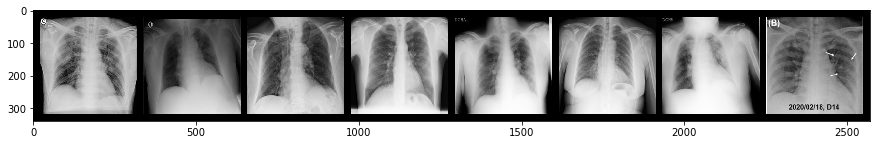

Class: Normal


<Figure size 432x288 with 0 Axes>

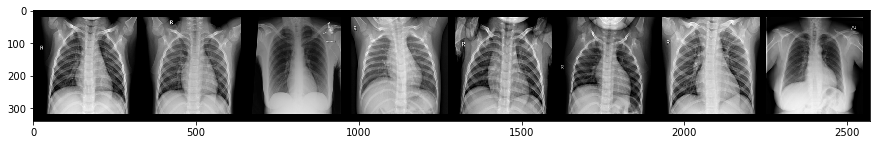

Class: Viral Pneumonia


<Figure size 432x288 with 0 Axes>

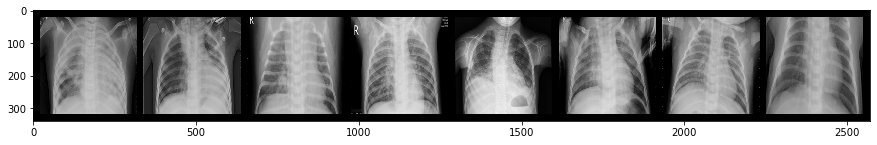

<Figure size 432x288 with 0 Axes>

In [7]:
def show_batch_images(dataset):
    n_images, scale = 8, 3
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle = True)
    images, labels = next(iter(data_loader))
    for i in range(len(categories)):
        print(f'Class: {categories[i]}')
        images_category = images[labels==i][:n_images]
        grid = torchvision.utils.make_grid(images_category, padding=20)
        npgrid = grid.cpu().numpy()
        plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
        plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        plt.show()
        plt.savefig('x-ray[i].pdf')  

show_batch_images(train_data)

In [8]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

In [9]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

def train_val_model(model):
    t_start = time.time()
    global best_val_model
    global best_val_loss
    best_val_loss = 1
    global best_val_epoch
    best_val_epoch = 0
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        if epoch >= best_val_epoch + 15:
            break
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def train_val_model_kfold(model, train_loader_kfold):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs")
    train_size = len(train_loader_kfold)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        #model.train()
        train_loss = 0.0
        for i, (data, target) in enumerate(train_loader_kfold):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size]
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def accuracy_model(model, loader):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

In [10]:
from tqdm import tqdm
from torchvision import models
# load pretrain model and modify...
model = models.mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

#num_ftrs = model.fc.in_features
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
#model.fc = nn.Linear(num_ftrs, num_classes)

model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [11]:
np.random.seed(seed)
torch.manual_seed(seed)
model_name = 'MobileNetV2'
n_epochs = 20
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

mobileNetV2_model, df_epochs = train_val_model(model)

Training model MobileNetV2 with 600 samples and max of 20 epochs, and validating with 75 samples

Epoch 1:	 train loss=1.13711 	 val loss=1.06013 	 time=64.81s
Epoch 2:	 train loss=1.05987 	 val loss=0.97972 	 time=82.89s
Epoch 3:	 train loss=1.00027 	 val loss=0.93993 	 time=69.71s
Epoch 4:	 train loss=0.94999 	 val loss=0.89996 	 time=73.49s
Epoch 5:	 train loss=0.91297 	 val loss=0.85079 	 time=79.26s
Epoch 6:	 train loss=0.87186 	 val loss=0.79467 	 time=76.13s
Epoch 7:	 train loss=0.84508 	 val loss=0.75750 	 time=71.92s
Epoch 8:	 train loss=0.82156 	 val loss=0.72344 	 time=72.13s
Epoch 9:	 train loss=0.79586 	 val loss=0.68998 	 time=75.87s
Epoch 10:	 train loss=0.76888 	 val loss=0.66276 	 time=78.66s
Epoch 11:	 train loss=0.73389 	 val loss=0.64009 	 time=76.60s
Epoch 12:	 train loss=0.71593 	 val loss=0.62226 	 time=74.86s
Epoch 13:	 train loss=0.70811 	 val loss=0.59387 	 time=83.88s
Epoch 14:	 train loss=0.68978 	 val loss=0.57752 	 time=74.10s
Epoch 15:	 train loss=0.67669

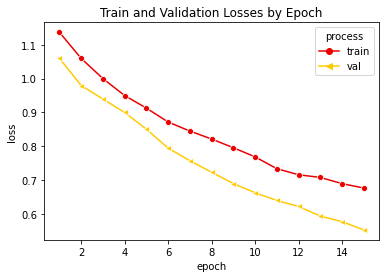

In [12]:
plot_train_val_losses(df_epochs)

In [13]:
test_results, conf_matrix_test = accuracy_model(mobileNetV2_model, test_loader)

Testing the model MobileNetV2 with 75 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.973333   0.973846  0.973333  0.973328


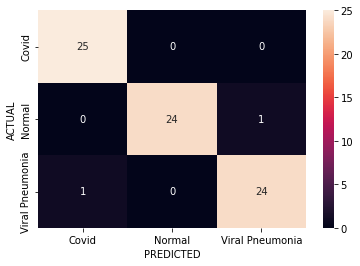

In [14]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

In [15]:
torch.save(mobileNetV2_model.state_dict(), os.path.join(MODEL_PATH, 'mobileNetV2.pth'))

In [16]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
dataset = ImageFolder(DATA_PATH, 
                     transform=transforms.Compose([
                         transforms.Resize(299),
                         transforms.CenterCrop(299),
                         transforms.ToTensor(), 
                     ]))
print(dataset)
dataloader = DataLoader(dataset, batch_size=32, shuffle = False)

Dataset ImageFolder
    Number of datapoints: 750
    Root location: C:/Users/LENOVO/Desktop/COVID Project/CovidData
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(299, 299))
               ToTensor()
           )


In [17]:
def RandomImagePrediction(filepath):
    img_array = Image.open(filepath).convert("RGB")
    data_transforms=transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299), 
        transforms.ToTensor(), 
    ])
    img = data_transforms(img_array).unsqueeze(dim=0) 
    load = DataLoader(img)
    
    for x in load:
        x=x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        print(f"class : {preds}")
        if preds[0] == 0: print(f"predicted ----> COVID")
        elif preds[0] == 1: print(f"predicted ----> NORMAL")
        else: print(f"predicted ----> PNEUMONIC")

In [18]:
if __name__ == "__main__":
    RandomImagePrediction("C:/Users/LENOVO/Desktop/COVID Project/CovidData/val/Covid/COVID-230.png") 
    RandomImagePrediction("C:/Users/LENOVO/Desktop/COVID Project/CovidData/val/Normal/Normal-241.png") 
    RandomImagePrediction("C:/Users/LENOVO/Desktop/COVID Project/CovidData/val/Viral Pneumonia/Viral Pneumonia-247.png") 

class : tensor([0])
predicted ----> COVID
class : tensor([1])
predicted ----> NORMAL
class : tensor([2])
predicted ----> PNEUMONIC


In [19]:
import anvil.server

anvil.server.connect("ZOWPHTHH7UTXEWTWRKARPK2P-YSKMUI6OSW7E7V2L")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [20]:
import anvil.media

@anvil.server.callable
def predict_image(file):
    with anvil.media.TempFile(file) as filename:
        img_array = Image.open(filename).convert("RGB")
    data_transforms=transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299), 
        transforms.ToTensor(), 
    ])
    img = data_transforms(img_array).unsqueeze(dim=0)
    load = DataLoader(img)
    
    for x in load:
        x=x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        print(f"class : {preds}")
        if preds[0] == 0: return "COVID"
        elif preds[0] == 1: return "NORMAL"
        else: return "PNEUMONIC"

class : tensor([1])
